# 1. Import Libraries

In [42]:
#Importing necessary libraries and functions
#General
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Deactivation of warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 2. Import Data and Exploratory Analysis

In [43]:
#import dataset
data = np.loadtxt('wifi_localization.txt',dtype=int)
col = ['wifi1','wifi2','wifi3','wifi4','wifi5','wifi6','wifi7','room']
df = pd.DataFrame(data,columns=col)
#exploratory data analysis
df.head()

,wifi1,wifi2,wifi3,wifi4,wifi5,wifi6,wifi7,room
0,-64,-56,-61,-66,-71,-82,-81,1
1,-68,-57,-61,-65,-71,-85,-85,1
2,-63,-60,-60,-67,-76,-85,-84,1
3,-61,-60,-68,-62,-77,-90,-80,1
4,-63,-65,-60,-63,-77,-81,-87,1


In [44]:
df.tail()

,wifi1,wifi2,wifi3,wifi4,wifi5,wifi6,wifi7,room
1995,-59,-59,-48,-66,-50,-86,-94,4
1996,-59,-56,-50,-62,-47,-87,-90,4
1997,-62,-59,-46,-65,-45,-87,-88,4
1998,-62,-58,-52,-61,-41,-90,-85,4
1999,-59,-50,-45,-60,-45,-88,-87,4


In [45]:
df.groupby('room').count()

,wifi1,wifi2,wifi3,wifi4,wifi5,wifi6,wifi7
room,,,,,,,
1,500,500,500,500,500,500,500
2,500,500,500,500,500,500,500
3,500,500,500,500,500,500,500
4,500,500,500,500,500,500,500


# 3. Data Preprocessing

In [46]:
#Separation in train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('room',axis=1),
                                                    df['room'], 
                                                    test_size = 0.3, random_state = 0)
#Normalization of the Dataset
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
X_test.shape

(600, 7)

# 4. Define plotting function

In [47]:
#Function to plot Hyperparameters heatmap and confusion matrix

def plotting(hmap,cm,best,grid_params,model):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    sns.set(rc={'figure.figsize':(4,4)})
    ax1 = sns.heatmap(hmap,annot=True,cmap='Blues',fmt='f',cbar=False)
    ax1.set_title('Best Hyperparameters: ' + str(best))
    hmap_keys = list(grid_params.keys())
    ax1.set_xlabel(hmap_keys[1])
    ax1.set_ylabel(hmap_keys[0])
    
    plt.subplot(122)
    sns.set(rc={'figure.figsize':(4,4)})
    ax2 = sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',cbar=False)
    ax2.set_title('Confusion Matrix for ' + str(best))  
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.suptitle(model + ' Model',fontsize=16)

# 5. Model Generation

### 5.1. K-nearest neighbors

In [48]:
#Definition of k from values between 1 and 10
k = list(range(1,11))

#Dictionary of arguments to pass to GridSearchDV
grid_params = {'n_neighbors':k,'weights':['uniform','distance']}

#Model generation
gs = GridSearchCV(KNeighborsClassifier(),grid_params,cv=4)
gs_results = gs.fit(X_train,y_train)
#We obtain the mean of the iterations
a = gs_results.cv_results_['mean_test_score']
#Best parameters obtained with the GridSearchCV
gs_results.best_params_

{'n_neighbors': 6, 'weights': 'uniform'}

In [49]:
#KNN model with best parameters
knn = KNeighborsClassifier(n_neighbors = gs_results.best_params_['n_neighbors'], 
                           weights = gs_results.best_params_['weights'])
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=6)

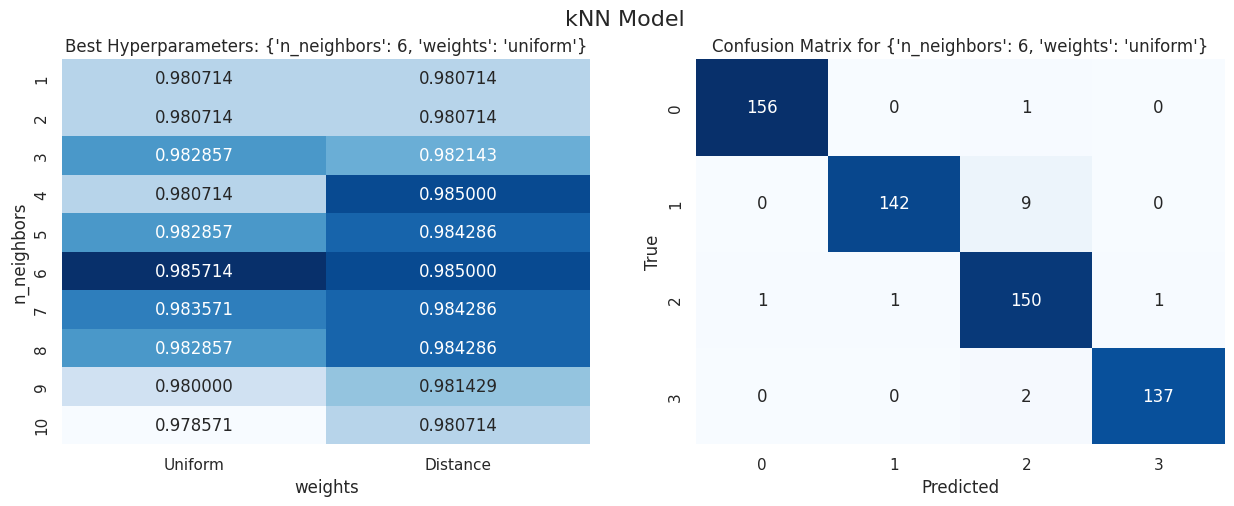

In [50]:
#Prediction
y_pred = knn.predict(X_test)
#Dataframe to create heatmap
b=a.reshape(10,2)
heatmap_df = pd.DataFrame(data=b,index=k,columns=['Uniform','Distance'])

#Accuracy & confusion matrix
accuracies = {'kNN':knn.score(X_train,y_train)}
c_matrix = confusion_matrix(y_test, y_pred)

#Plot
plotting(heatmap_df,c_matrix,gs_results.best_params_,grid_params,'kNN')


### 5.2. Support Vector Machines (SVM)


In [51]:
#Definition of values for C & gamma
c = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma = [0.001, 0.01, 0.1, 1, 10]

#Dictionary of arguments to pass to GridSearchDV
grid_params_svc = {'C':c,'gamma':gamma}

#Model generation
gs_svc = GridSearchCV(SVC(),grid_params_svc,cv=4)
gs_results_svc = gs_svc.fit(X_train,y_train)

#We obtain the mean of the iterations
a = gs_results_svc.cv_results_['mean_test_score']
#Best parameters obtained with the GridSearchCV
gs_results_svc.best_params_

{'C': 10, 'gamma': 0.1}

In [52]:
# SVM model with best hyperparameters
svc = SVC(C = gs_results_svc.best_params_['C'], gamma = gs_results_svc.best_params_['gamma'], probability=True)  
svc.fit(X_train,y_train)

SVC(C=10, gamma=0.1, probability=True)

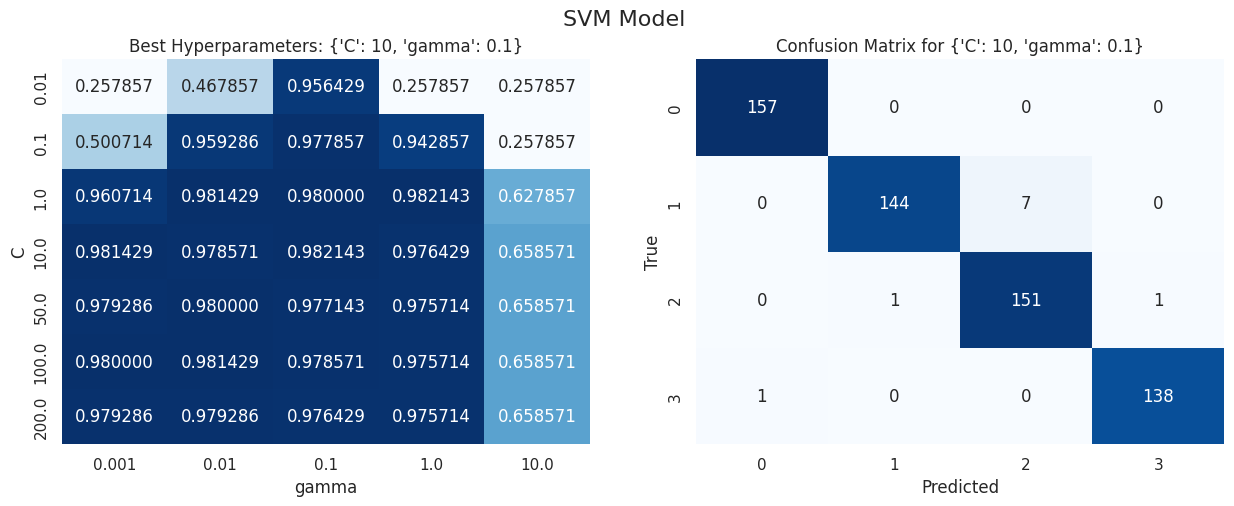

In [53]:
#Prediction
y_pred_svc = svc.predict(X_test)
#Dataframe to create heatmap
b=a.reshape(7,5)
heatmap_df_svc = pd.DataFrame(data=b,index=c,columns=gamma)

#Accuracy & confusion matrix
accuracies.update({'SVM':svc.score(X_train,y_train)})
c_matrix_svc = confusion_matrix(y_test, y_pred_svc)

#Plot
plotting(heatmap_df_svc,c_matrix_svc,gs_results_svc.best_params_,grid_params_svc,'SVM')


### 5.3. Decision Trees

In [54]:
#Definition of values for depth & samples
depth = list(range(3,10))
samples = [2, 10, 20, 50, 100]

#Dictionary of arguments to pass to GridSearchDV
grid_params_dt = {'max_depth':depth,'min_samples_split':samples,'random_state':[0]}

#Model generation
gs_dt = GridSearchCV(DecisionTreeClassifier(),grid_params_dt,cv=4)
gs_results_dt = gs_dt.fit(X_train,y_train)

#We obtain the mean of the iterations
a = gs_results_dt.cv_results_['mean_test_score']
#Best parameters obtained with the GridSearchCV
gs_results_dt.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'random_state': 0}

In [55]:
# DT model with best hyperparameters
dt = DecisionTreeClassifier(max_depth = gs_results_dt.best_params_['max_depth'], 
                            min_samples_split = gs_results_dt.best_params_['min_samples_split'])
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4)

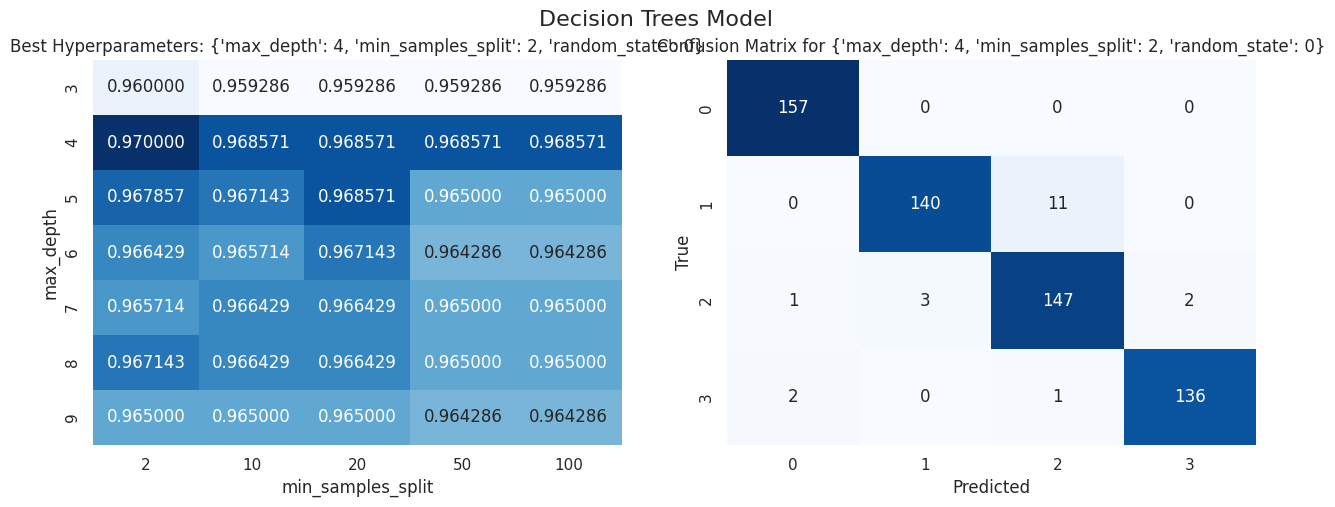

In [56]:
#Prediction
y_pred_dt = dt.predict(X_test)
#Dataframe to create heatmap
b=a.reshape(7,5)
heatmap_df_dt = pd.DataFrame(data=b,index=depth,columns=samples)

#Accuracy & confusion matrix
accuracies.update({'DecisionTree':dt.score(X_train,y_train)})
c_matrix_dt = confusion_matrix(y_test, y_pred_dt)

#Plot
plotting(heatmap_df_dt,c_matrix_dt,gs_results_dt.best_params_,grid_params_dt,'Decision Trees')


# 6. Model Accuracy Comparison

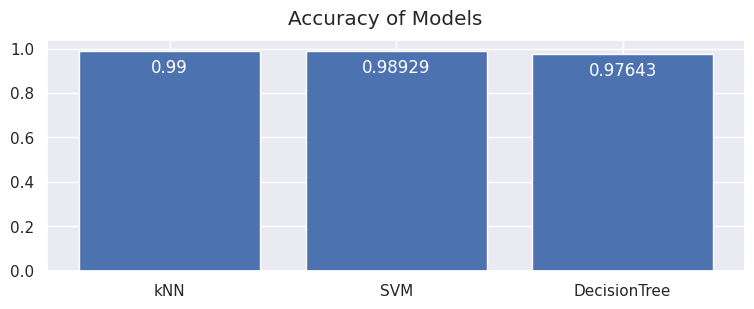

In [57]:
models = list(accuracies.keys())
values = list(accuracies.values())
valuesRounded =  [round(x,5) for x in values] 

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
ax.bar(models, valuesRounded)

fig.suptitle('Accuracy of Models')

for p in ax.patches:
    b = str(p.get_height())
    ax.annotate(b,xy=(p.get_x()+(p.get_width()/2),p.get_height()-0.10),ha='center',color="white")
